Import required modules.

In [1]:
%matplotlib inline
import numpy as np
import nltk
import os
import os.path
import scipy as sp

import math

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cross_validation
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import normalize

from sklearn.metrics.pairwise import pairwise_distances
import itertools
import pyprind
import psutil
import joblib

Functions

In [43]:
def getCorpus(lines):
    ids = list()
    labels = list()
    corpus = list()
    for line in lines:
        strs=line.rstrip('\n').split("\t",2)
        ids.append(strs[0])
        labels.append(strs[1])
        corpus.append(strs[2])
    return ids,labels,corpus

def loadMultiDomainData(domain):
    posFile = "{0}/data/domains/{1}/positive.review.text".format(os.environ['HOME'],domain)
    negFile = "{0}/data/domains/{1}/negative.review.text".format(os.environ['HOME'],domain)
    
    posLines = tuple(open(posFile,'r'))
    negLines = tuple(open(negFile,'r'))

    
    p_ids,p_labels,p_corpus = getCorpus(posLines)
    n_ids,n_labels,n_corpus = getCorpus(negLines)

    return p_ids+n_ids,p_labels+n_labels,p_corpus+n_corpus
    
def classConditionalProbs(X,Y,classLabels,smoothing='None'):
    noOfFeatures=X.shape[1]
    Xprime = np.ndarray((len(classLabels),noOfFeatures),dtype=float)
    
    if smoothing == 'additive':
        for c in classLabels:
            indices = [i for i, x in enumerate(Y) if x == c]
            Xprime[c,:]=(X[indices,:].sum(axis=0)+1)/(len(indices)+noOfFeatures)
    else:
        for c in classLabels:
            indices = [i for i, x in enumerate(Y) if x == c]
            Xprime[c,:]=X[indices,:].sum(axis=0)/len(indices)

    return Xprime;

def symKlDivergence(P,Q,classLabels):
    kldC=0.0;
    for c in classLabels:
        kldST=sp.stats.entropy(P[c,:],Q[c,:])
        kldTS=sp.stats.entropy(Q[c,:],P[c,:])
        kldC+=(kldST+kldTS);
    
    return kldC;

def generate_WS_matrix(A,B):
    nA = len(A);
    nB = len(B);
    simMat = np.ndarray((nA+nB,nA+nB),dtype=float)
    diffMat = np.ndarray((nA+nB,nA+nB),dtype=float)
    C = A+B;
    nC=nA+nB;
    
    ticks = (nC*(nC+1)/2);
    bar = pyprind.ProgBar(ticks,monitor=True)
    for c in itertools.combinations(range(nC),2):
            bar.update()
            i=c[0];
            j=c[1];
            if(C[i]==C[j]):
                simMat[i,j]=1.0;
            else:
                diffMat[i,j]=1.0;
    
    simMat = sp.sparse.csc_matrix(simMat+simMat.transpose()+np.eye(nC))
    diffMat = sp.sparse.csc_matrix(diffMat+diffMat.transpose())
    print(bar)    
    return simMat,diffMat;


def generate_topology_matrix(A,B):
    nA = A.shape[0];
    nB = B.shape[0];
    tMat = np.ndarray((nA+nB,nA+nB),dtype=float)
    C = sp.sparse.vstack((A, B), format='csr');
    
    nC=nA+nB;
    
    ticks = (nC*(nC+1)/2);
    bar = pyprind.ProgBar(ticks,monitor=True)
    for i in itertools.combinations(range(nA+nB),2):
        bar.update()
        xa = C[i[0],:]
        xb = C[i[1],:]
        dist=pairwise_distances(xa,xb)[0][0]
        tMat[i[0],i[1]]=math.exp(-1*dist*dist)    
    
    
    tMat = sp.sparse.csc_matrix(tMat+tMat.transpose())
    print(bar)
    return tMat;

def laplacian_matrix(A):
    D=sp.sparse.csc_matrix(simMat.sum(axis=0)).multiply(sp.sparse.eye(simMat.shape[0]));
    return D-A;

def reweighting_scheme_01():
    pass

Load Multidomain Data

In [313]:
s_ids,s_labels,s_corpus=loadMultiDomainData('dvd')
t_ids,t_labels,t_corpus=loadMultiDomainData('electronics')

subSetSize = 1000;
data_s = s_corpus[0:0+subSetSize]+s_corpus[1000:1000+subSetSize]
data_t = t_corpus[0:0+subSetSize]+t_corpus[1000:1000+subSetSize]

vectorizer = CountVectorizer(min_df=1,stop_words='english',binary=True)
X=vectorizer.fit_transform(data_s+data_t);
Y = [1]*subSetSize+[0]*subSetSize+[1]*subSetSize+[0]*subSetSize

# Small subset for quick development and validation.
# subSetSize=40;
# XS = sp.sparse.vstack((X[0:0+subSetSize,:], X[1000:1000+subSetSize,:]), format='csr')
# XT = sp.sparse.vstack((X[2000:2000+subSetSize,:], X[3000:3000+subSetSize,:]), format='csr')
# YS = Y[0:0+subSetSize]+Y[1000:1000+subSetSize];
# YT = Y[2000:2000+subSetSize]+Y[3000:3000+subSetSize]

# Complete data set
XS=X[0:2*subSetSize,:]
XT=X[2*subSetSize:4*subSetSize,:]
YS=Y[0:2*subSetSize]
YT=Y[2*subSetSize:4*subSetSize]



In [314]:
A =XS.todense();#np.matrix('1 1 1 1;2 2 2 2;3 3 3 3')
B =XT.todense();#np.matrix('1 1 1 1;2 2 2 2;3 3 3 3')

epsilon = 0.1;
vocab = A.shape[1];
alpha = np.ones(shape=(vocab,1))
alpha = alpha/vocab;


B_L = A.sum(axis=0).transpose()
B_L = B_L/A.shape[0]

for i in range(0,10):
    alpha=alpha+epsilon*B.transpose()*np.divide(1,np.dot(B,alpha));
    alpha=alpha+np.divide((B_L*(1-B_L.transpose()*alpha)),B_L.transpose() * B_L);
    alpha=np.maximum(0,alpha)
    alpha = alpha / (B_L.transpose()*alpha);

    
    
# #     for i in range(0,4):
# #         alpha = alpha + epsilon*B
#     print(B.transpose().shape)
#     print(np.divide(1,B*alpha).shape)
#     print((B.transpose()*np.divide(1,B*alpha)).shape)
#     #np.divide(1,B*alpha)
#     #
#     #print(B_L.shape,alpha.shape)
#     #np.dot(B_L.transpose(),alpha)
    
#     #print(B_L.transpose()*B_L)
X1=sp.sparse.csc_matrix(np.multiply(alpha.transpose(),A))
X2=sp.sparse.csc_matrix(np.multiply(alpha.transpose(),B))
klDivergence(X1,X2)

array([ 0.08948183])

In [299]:
def klDivergence(XS,XT):
    A=(XS.sum(axis=0).transpose()+1)/(XS.shape[0]+XS.shape[1])
    B=(XT.sum(axis=0).transpose()+1)/(XT.shape[0]+XT.shape[1])
    KAB=sp.stats.entropy(A,B)
    KBA=sp.stats.entropy(B,A)
    return KAB+KBA;

In [315]:
clf3 = svm.SVC(kernel='linear', C=1)
clf3.fit(XS,YS);
pred = clf3.predict(XT);
accuracy_score(YT,pred)

0.69350000000000001

In [316]:
clf3 = svm.SVC(kernel='linear', C=1)
clf3.fit(X1,YS);
pred = clf3.predict(X2);
accuracy_score(YT,pred)

0.64600000000000002

In [20]:
uss = sp.sparse.csc_matrix(us)

In [27]:
A=np.dot(us.transpose(),us)
np.linalg.det(A)

1.0000000000000386

KL Divergence

In [25]:
 # Class conditional probablities.
classLabels=np.unique(YS+YT)
XSC=classConditionalProbs(XS,YS,classLabels,'additive')
XTC=classConditionalProbs(XT,YT,classLabels,'additive')

#Normalize
XSC=normalize(XSC,norm='l1')
XTC=normalize(XTC,norm='l1')

# Calculate Symmetric KL Divergence.
kld=symKlDivergence(XSC,XTC,classLabels)

Functions specific to reweighting with labels.


In [80]:
simMat,diffMat = generate_WS_matrix(YS,YT);

0%                          100%
[#######################       ] | ETA: 00:00:00

Title: 
  Started: 04/05/2016 14:31:16
  Finished: 04/05/2016 14:31:16
  Total time elapsed: 00:00:00
  CPU %: 76.70
  Memory %: 3.96


In [81]:
tMat=generate_topology_matrix(XS,XT);

0%                          100%
[#######################       ] | ETA: 00:00:00

Title: 
  Started: 04/05/2016 14:31:19
  Finished: 04/05/2016 14:31:19
  Total time elapsed: 00:00:00
  CPU %: 96.90
  Memory %: 3.96


Z: feature-instance matrix.

In [82]:
XSt=XS.transpose()
XTt=XT.transpose()
zeroMat=sp.sparse.csc_matrix(XSt.shape,dtype=np.int64)
s1=sp.sparse.vstack((XSt,zeroMat), format='csc')
s2=sp.sparse.vstack((zeroMat,XTt), format='csc')
Z =sp.sparse.hstack((s1,s2), format='csc')

In [83]:
LS = laplacian_matrix(simMat)
LD = laplacian_matrix(diffMat)
L = laplacian_matrix(tMat)

In [99]:
A= Z*sp.around(0.1*L+LS)*Z.transpose()
B= Z*sp.around(LD)*Z.transpose()

In [105]:
np.linalg.det(A.todense())

0.0

In [106]:
np.linalg.det(B.todense())

0.0

[0.69350000000000001]
[array([ 1.34986202])]
[0.0073253002886228043, 0.0036677579783220516, 0.0025067549327676599, 0.0018699002260672689, 0.0016193854917121425, 0.0013925401631254743, 0.0012682294372651512, 0.0012021704062280497, 0.0011165179105610476, 0.0010248453628987802]


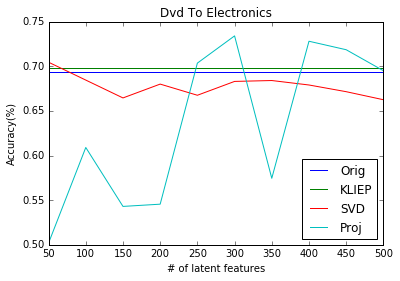

In [329]:
import joblib
from collections import namedtuple
import matplotlib.pyplot as plt

src="dvd"
tgt="electronics"
Score=namedtuple('Score',['t','s'])
scoreList=joblib.load("/home/arun/data/covariate/mahadev/%s_%s"%(src,tgt))
original=[]
svd=[]
proj=[]

original_kl=[]
svd_kl=[]
proj_kl=[]
    
for score in scoreList:
    if(score.t.endswith("_kl")):
        if(score.t.startswith("original")):
            original_kl.append(score.s)
        elif(score.t.startswith("svd")):
            svd_kl.append(score.s)
        elif(score.t.startswith("proj")):
            proj_kl.append(score.s)        
    else:
        if(score.t.startswith("original")):
            original.append(score.s)
        elif(score.t.startswith("svd")):
            svd.append(score.s)
        elif(score.t.startswith("proj")):
            proj.append(score.s)           
   
# Plots
X = range(50,550,50)
plt.plot(X,original[0]*np.ones(10),label='Orig')
plt.plot(X,0.698*np.ones(10),label='KLIEP')
plt.plot(X,svd,label='SVD')
plt.plot(X,proj,label='Proj')
plt.xlabel("# of latent features")
plt.ylabel("Accuracy(%)")
plt.title(("%s to %s"%(src,tgt)).title())
plt.legend(loc=4)
plt.savefig("%s_%s.png"%(src,tgt),dpi=300)

print(original)
print(original_kl)
print(proj_kl)


In [25]:
"arun reddy".title()

'Arun Reddy'

In [122]:
np.linalg.det((XS.transpose()*XS).todense())

0.0

In [123]:
import gensim

In [124]:
import gensim.models.word2vec as wv

In [144]:
model=wv.Word2Vec(data_s, size=100, window=5, min_count=5, workers=4)

In [128]:
data_s

["Bridget Jones, modern day woman, brillant and doesn't know it, prone to accidents and mess ups but manages to come out of them.  This is the book that started it all with the chick lit fever.  Bridget Jones is my hero!",
 "I am ordering copies for all 23 middle school principals and the two assistant principals leading two middle school programs in the Milwaukee Public Schools system. We will use Wheatley's book as the primary resource  for our professional growth at our MPS Middle School Principals  Collaborative institute August 9-11, 1999. We are not just concerned with  reform; we seek renewal as well. Wheatley provides the basis. She notes  that Einstein said that  a problem cannot be solved from the same  consciousness that created it. The entire book is a marvelous exploration  of this philosophy",
 "This book has its good points. If anything, it helps you put into words what you want  from a supervisor, but it is not very accurate. The online test does not account for a diffe

In [150]:
sentences = [['first', 'sentence'], ['second', 'sentence']]
model = gensim.models.Word2Vec(sentences, min_count=1)
model.vocab

{'first': <gensim.models.word2vec.Vocab at 0x7f0d5de3f358>,
 'second': <gensim.models.word2vec.Vocab at 0x7f0d5de3f390>,
 'sentence': <gensim.models.word2vec.Vocab at 0x7f0d5de3f3c8>}

In [180]:
sentences = []
for line in data_s:
    sentences.append(line.lower().split())
    

model = gensim.models.Word2Vec(sentences,size=100, window=5, min_count=2, workers=4)

In [181]:
len(model.vocab)

14635

In [182]:
model.most_similar(positive=['book'])

[('book.', 0.7548404335975647),
 ('book,', 0.6584270000457764),
 ('fluff.', 0.6485207080841064),
 ('mccullough', 0.6412122845649719),
 ('novel', 0.6236221790313721),
 ('disappointing', 0.6097298860549927),
 ('battle.', 0.6055798530578613),
 ('play.', 0.5934592485427856),
 ('results,', 0.5825697183609009),
 ('memoir', 0.579273521900177)]

In [183]:
model.most_similar(positive=['negative'])

[('includes', 0.8936773538589478),
 ('becomes', 0.8905996084213257),
 ('creates', 0.8815507888793945),
 ('young', 0.8695155382156372),
 ('unique', 0.8691244125366211),
 ('necklace,', 0.8602585792541504),
 ('sam', 0.8529733419418335),
 ('policy', 0.8471596837043762),
 ('paints', 0.8461211323738098),
 ('brooding', 0.8435299396514893)]